In [ ]:
%matplotlib nbagg
%matplotlib inline
import MDAnalysis as mda
import MDAnalysis.analysis.leaflet
import matplotlib
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nglview as nv
import copy
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = '/home/julie/analysis/bilayer/3-5-2/DIPC_DPPC_chol_GM1_20/'
fgro = 'start_mb.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_20_43nm_mb_fixed_t1.xtc'

In [1]:
u = mda.Universe( path+fgro, path+fxtc)

NameError: name 'mda' is not defined

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


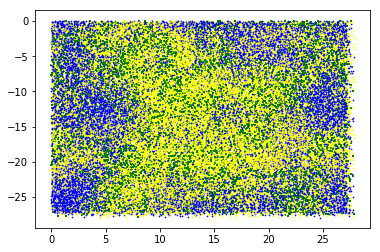

In [5]:
# boucle pour travailler sur des frames de la simu

tmes = 1000
for ts in u.trajectory:
     if (ts.frame%tmes == 0):
            print(ts.frame)
            xmin=0
            ymin=0
            str_sel= "(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and (name GL1 or name AM1)"
            patch = u.select_atoms(str_sel).positions
            
            Lo = u.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name PO4 and resname DPPC").positions
            Ld = u.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name PO4 and resname DIPC").positions
            GM1 = u.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name AM1").positions
            chol = u.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name ROH").positions

            xmax = max(patch[:,0])
            ymax = max(patch[:,1])
            
            xmin = min(patch[:,0])
            ymin = min(patch[:,1])
            
            N = 15
            dx = (xmax-xmin)/N
            dy = (ymax-ymin)/N
            plt.scatter(Lo[:,1]/N, -Lo[:,0]/N, marker='.', c='yellow', s=2)
            plt.scatter(Ld[:,1]/N, -Ld[:,0]/N, marker='.', c='b', s=2)
            plt.scatter(GM1[:,1]/N, -GM1[:,0]/N, marker='+', c='g', s=2)
            # plt.savefig('t'+str(ts.frame)+'.pdf', format='pdf',bbox_inches='tight')
            # pour enregistrer les plots


In [46]:
def F_neigh(n) :
    neigh[0] = n
    i=n%N
    j=int(n/N)
    ip1=(i+1)%N
    im1=(i-1)%N
    jp1=(j+1)%N
    jm1=(j-1)%N
    neigh[1] = ip1+N*j
    neigh[2] = im1+N*j
    neigh[3] = i+N*jm1
    neigh[4] = i+N*jp1

def Lap(n) :
    lap = ( h[neigh[4]]+h[neigh[3]]-2*h[neigh[0]] ) / dx**2 + ( h[neigh[1]]+h[neigh[2]]-2*h[neigh[0]] ) / dy**2
    return(lap)


In [58]:
# boucle pour calculer la courbure au cours du temps
Ct = []
t = []
tmes = 1000
for ts in u.trajectory:
     if (ts.frame%tmes == 0):
            print(ts.frame)
            xmin=0
            ymin=0
            str_sel= "(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and (name GL1 or name AM1)"
            patch = u.select_atoms(str_sel).positions
            
            xmax = max(patch[:,0])
            ymax = max(patch[:,1])
            
            xmin = min(patch[:,0])
            ymin = min(patch[:,1])
            
            N = 15
            dx = (xmax-xmin)/N
            dy = (ymax-ymin)/N
           
            Lf = mda.analysis.leaflet.LeafletFinder(u, 'name GL1 or name AM1')
            leaflet0 = Lf.groups(0)
            leaflet1 = Lf.groups(1)
            
            # lower leaflet
            bary0 = []

            for i in range(0,N):
                xs = xmin + i*dx
                for j in range(0,N):
                    ys = ymin + j*dy
                    str_sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and (name GL1 or name AM1)"
                    b0=leaflet0.select_atoms(str_sel).centroid().tolist()
                    bary0.append(b0)
                    
            # upper leaflet
            bary1 = []

            for i in range(0,N):
                xs = xmin + i*dx
                for j in range(0,N):
                    ys = ymin + j*dy
                    str_sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and (name GL1 or name AM1)"
                    b1=leaflet1.select_atoms(str_sel).centroid().tolist()
                    bary1.append(b1)

            bary0=np.array(bary0)
            bary1=np.array(bary1)
            
            neigh = [0,0,0,0,0]
            h=bary0[:,2]
            laplacian = []
            
            for i in range(N*N) :
                F_neigh(i)
                laplacian.append(Lap(i))
                
            curv = copy.copy(bary0)
            curv[:,2] = laplacian
            C = curv[:,2]
            C.shape=(N,N)
            
            t.append(ts.frame)
            Ct.append(np.mean(C))
            print(np.mean(C))


0
9.251858538542972e-20
1000
3.0839528461809904e-20
2000
6.167905692361981e-20
3000
-3.0839528461809904e-20
4000
1.5419764230904952e-20
5000
1.5419764230904953e-19
6000
0.0
7000
-6.167905692361981e-20
8000
0.0
9000
1.2335811384723962e-19


[9.251858538542972e-20, 3.0839528461809904e-20, 6.167905692361981e-20, -3.0839528461809904e-20, 1.5419764230904952e-20, 1.5419764230904953e-19, 0.0, -6.167905692361981e-20, 0.0, 1.2335811384723962e-19]
(225, 3)


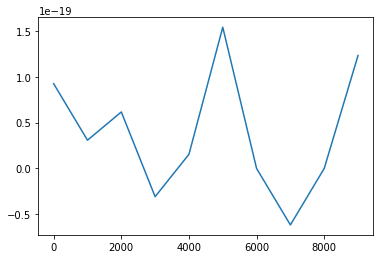

In [59]:
print(Ct)
print(np.shape(bary0))
plt.plot(t,Ct)

In [35]:
# boucle pour suivre un lipide pendant la trajectoire pour calculer le MSD et le coeff de diffusion
tmes = 10
traj = []
for ts in u.trajectory:
     if (ts.frame%tmes == 0):
            #print(ts.frame)
            str_sel= "name GL1 and resname DIPC"
            p = u.select_atoms(str_sel).positions
            traj.append(p)
            


(1000, 1617, 3)


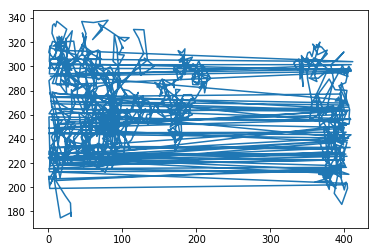

In [43]:
t = np.array(traj)
nbr=15 # indice du lipide que l'on suit
print(np.shape(t)) # nb de frames - indice du lipide - coordonnées
x=t[:,nbr,0]
y=t[:,nbr,1]
plt.plot(x,y)